**Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Libraries**

In [2]:
!pip install fastai --upgrade -q

     |████████████████████████████████| 194kB 7.3MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 


In [63]:
from fastai.vision.all import *

from fastai.metrics import accuracy_multi
from torchvision.models import resnet34

from sklearn.metrics import average_precision_score, roc_auc_score

import PIL

In [4]:
path = Path('drive/My Drive/Dataset/RFMID/data')

In [5]:
!ls 'drive/My Drive/Dataset/RFMID/data/Training_Set/Training/' -1 | wc -l

1920


### Get Data

In [6]:
df = pd.read_csv(path/'Training_Set/RFMiD_Training_Labels.csv')

In [7]:
df

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1916,1917,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1917,1918,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1918,1919,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Disease Screening Data

In [8]:
def get_dls(bs, size):
  batch_tfms = [*aug_transforms(do_flip=True, flip_vert=True, max_rotate=180, min_zoom=1.0, max_zoom=1.2, size=size, min_scale=0.75), Normalize]

  dblock = DataBlock(blocks=(ImageBlock(),CategoryBlock()),
                     splitter=RandomSplitter(),
                    get_x=ColReader(0, pref=f'{path}/Training_Set/Training/', suff='.png'),
                    get_y=ColReader(1),
                    item_tfms=Resize(1024),
                    batch_tfms=batch_tfms)
  
  return dblock.dataloaders(df, bs=bs)

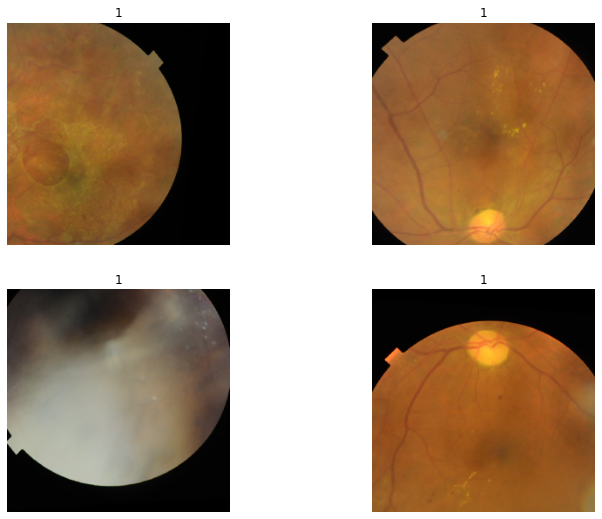

In [ ]:
dls = get_dls(16, 256)
dls.show_batch(max_n=4, figsize=(12,9))

### Disease Classification Data

In [9]:
classes = list(df.columns[2:])

In [10]:
def get_y(r): return r[classes].values.astype(np.int32)

In [11]:
def get_dls(bs, size):
  batch_tfms = [*aug_transforms(do_flip=True, flip_vert=True, max_rotate=180, min_zoom=1.0, max_zoom=1.2, size=size, min_scale=0.75), Normalize]

  dblock = DataBlock(blocks=(ImageBlock(),MultiCategoryBlock(encoded=True,vocab=classes)),
                    splitter=RandomSplitter(),
                    get_x=ColReader(0,pref=f'{path}/Training_Set/Training/', suff='.png'),
                    get_y=get_y,
                    item_tfms=Resize(1024),
                    batch_tfms=batch_tfms)
  
  return dblock.dataloaders(df, bs=bs)

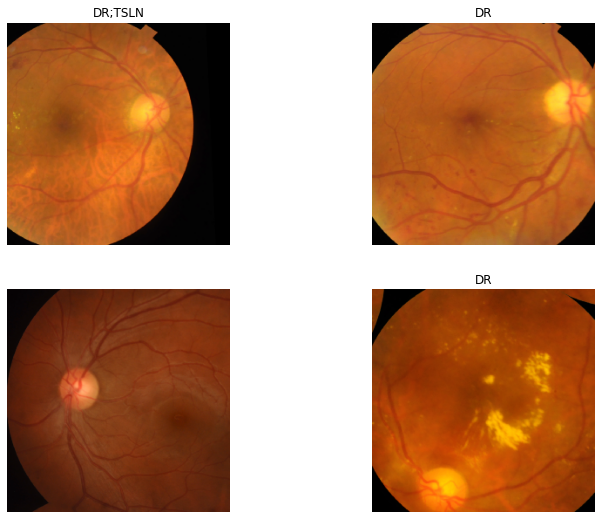

In [12]:
dls = get_dls(16, 256)
dls.show_batch(max_n=4, figsize=(12,9))

## Train Model

### Disease Screening

In [ ]:
model = xresnet50(n_out=dls.c)

In [ ]:
screener = Learner(dls, model, metrics=[accuracy, RocAucBinary()], loss_func=CrossEntropyLossFlat(), cbs=MixUp())
screener = screener.to_fp16()

In [ ]:
screener.freeze()
screener.fit_one_cycle(5, 3e-04)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.586947,0.480845,0.825521,0.749629,04:28
1,0.543859,0.455447,0.841146,0.774935,04:27
2,0.492379,0.428828,0.828125,0.787751,04:21
3,0.443960,0.415658,0.822917,0.791783,04:13
4,0.443690,0.392178,0.830729,0.813274,04:19


In [ ]:
screener.freeze_to(-1)
screener.fit_one_cycle(5, 6e-4)

KeyboardInterrupt: ignored

In [ ]:
screener.freeze_to(-2)
screener.fit_one_cycle(5, 1e-5)

In [ ]:
screener.freeze_to(-3)
screener.fit_one_cycle(5, 5e-5)

In [ ]:
screener.dls = get_dls(8, 512)

### Multi-Label

In [13]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [15]:
model = xresnet50(n_out=dls.c)

In [16]:
classifier = Learner(dls, model, metrics=[accuracy_multi], loss_func=BCEWithLogitsLossFlat())
classifier = classifier.to_fp16()

In [18]:
classifier.freeze()
classifier.fit_one_cycle(5, slice(5e-02))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.166903,0.165144,0.958984,10:16
1,0.146645,0.149175,0.961217,03:57
2,0.137807,0.135926,0.961216,03:54
3,0.132281,0.134535,0.960380,03:53
4,0.127092,0.127671,0.961124,03:53


In [ ]:
classifier.freeze_to(-1)
classifier.fit_one_cycle(5, slice(1e-03))

## Results

### Disease Screening Results

### Classifier Results

In [19]:
preds, targs = classifier.tta()
targs = np.array(targs)

In [75]:
thresh = 0.3
predictions = np.array([[1 if p > thresh else 0 for i,p in enumerate(pred)] for pred in preds])

In [76]:
average_precision_score(targs, predictions)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


nan

In [77]:
p, y = [], []

for pred, targ in zip(predictions, targs):
  if np.sum(pred) >= 1:
    p.append(1)
  else:
    p.append(0)
  if np.sum(targ) >= 1:
    y.append(1)
  else:
    y.append(0)

In [74]:
roc_auc_score(y, p)

0.5495073493781296

In [61]:
y

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
